In [1]:
import json
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In this example, we'll calibrate a spectrum from the DEep Imaging Multi-Object Spectrograph (DEIMOS) instrument on Keck. We load an example calibration spectrum from the `pypeit` library. (This requires the installation of the latest version on github as of 6 April 2020: pip3 install git+https://github.com/pypeit/PypeIt.git):

In [2]:
spectrum = json.load(open('data_keck_deimos/keck_deimos_830g_l_PYPIT.json'))

This spectrum is from the 830G grating and contains Ne, Ar, Kr arc lines.

<ipython-input-3-93f177344cc7>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot("110")


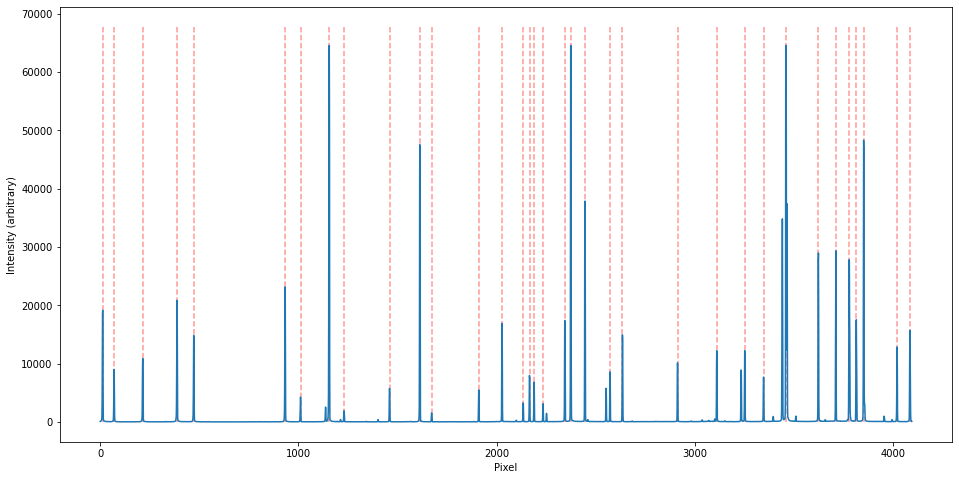

In [3]:
flux = spectrum['spec']

peaks, _ = find_peaks(flux, prominence=1000, distance=20)
peaks_refined = refine_peaks(flux, peaks, window_width=3)

intensity_range = max(flux) - min(flux)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot("110")
ax.plot(flux)

ax.vlines(peaks_refined,
          0,
          max(flux)+0.05*intensity_range,
          linestyle='dashed',
          alpha=0.4,
          color='red')
plt.xlabel("Pixel")
plt.ylabel("Intensity (arbitrary)")
plt.show()

As this is a reference template, it also has the wavelengths per pixel which we can use to check our calibration solution.

We'll use this as a hint for the spectral range of the instrument (setting the min/max range). To present a more fair scenario, we pick an approximate min/max and set a tolerance of 500A.

As usual we tell rascal the number of pixels on the detector, a fit tolerance appropriate to the instrument (in this case, we set a slightly lower fit tolerance.

In [4]:
c = Calibrator(peaks_refined,
               min_wavelength=6500,
               max_wavelength=10400,
               num_pix=len(flux))

c.set_fit_constraints(num_slopes=10000,
                      range_tolerance=500.,
                      fit_tolerance=10,
                      polydeg=7,
                      xbins=200,
                      ybins=200)

c.add_atlas(["Ne", "Ar", "Kr"], min_intensity=1000, vacuum=True)

TypeError: only integer scalar arrays can be converted to a scalar index

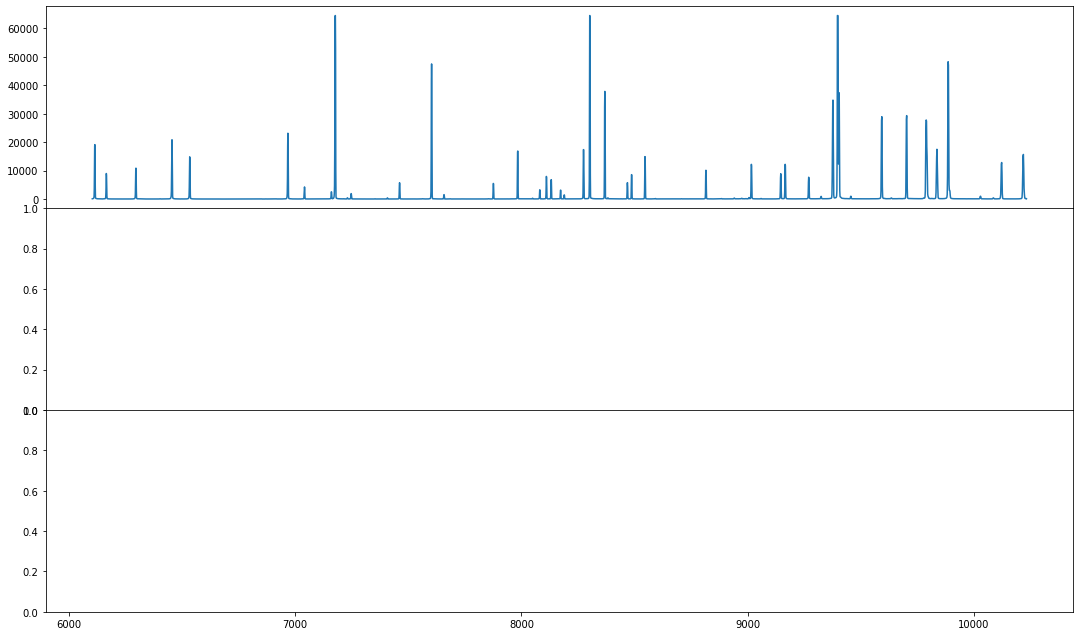

In [5]:
best_p, rms, residual, peak_utilisation = c.fit(max_tries=1000,
                                                sample_size=10,
                                                top_n=10,
                                                candidate_weighted=True,
                                                hough_weight=1.0,
                                                filter_close=True)

c.plot_fit(flux, best_p, plot_atlas=True, log_spectrum=False, tolerance=5.0, renderer='notebook')


rms = np.sqrt(np.sum(residual**2 / len(residual)))

print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

In [ ]:
c.plot_search_space()